In [1]:
import pandas as pd
import xarray as xr
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

## Get the forecast data

In [2]:
ct=datetime.datetime.now().date()

In [3]:
def subtract_days_from_date(date,days):
    subtracted_date=pd.to_datetime(date)-timedelta(days=days)
    subtracted_date=subtracted_date.strftime("%d-%m-%Y")

    return subtracted_date

In [4]:
adate=subtract_days_from_date(ct,1)

In [5]:
from datetime import datetime
adate1=datetime.strptime(adate, "%d-%m-%Y")
yyyy = adate1.strftime("%Y")
mm = adate1.strftime("%m")
dd = adate1.strftime("%d")

In [6]:
url=f'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs{yyyy}{mm}{dd}/gfs_0p25_00z'

In [7]:
ds = xr.open_dataset(url, engine='netcdf4')

In [8]:
ds

<xarray.Dataset>
Dimensions:         (time: 129, lev: 41, lat: 721, lon: 1440)
Coordinates:
  * time            (time) datetime64[ns] 2025-06-03 ... 2025-06-19
  * lev             (lev) float64 1e+03 975.0 950.0 925.0 ... 0.04 0.02 0.01
  * lat             (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon             (lon) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables: (12/215)
    absvprs         (time, lev, lat, lon) float32 ...
    no4lftxsfc      (time, lat, lon) float32 ...
    acpcpsfc        (time, lat, lon) float32 ...
    albdosfc        (time, lat, lon) float32 ...
    apcpsfc         (time, lat, lon) float32 ...
    capesfc         (time, lat, lon) float32 ...
    ...              ...
    vwshneg2pv      (time, lat, lon) float32 ...
    vwshtrop        (time, lat, lon) float32 ...
    watrsfc         (time, lat, lon) float32 ...
    weasdsfc        (time, lat, lon) float32 ...
    wiltsfc         (time, lat, lon) float32 ...
    var00212m       (time, lat, lon) float32 ...
Attributes:
    title:        GFS 0.25 deg starting from 00Z03jun2025, downloaded Jun 03 ...
    Conventions:  COARDS\nGrADS
    dataType:     Grid
    history:      Wed Jun 04 01:18:30 UTC 2025 : imported by GrADS Data Serve...

### Cut to Malaysian region

In [10]:
 ds_Malaysian=ds.sel(lon=slice(100,120),lat=slice(0,12))

### Get the heat index

In [11]:
def temp2F(ds):
    celcius = ds - 273.15
    fahrenheit = (celcius*(9/5))+32
    return fahrenheit

In [12]:
def calculate_heat_index(temperature_f, relative_humidity_percent):
    """
    Calculates the Heat Index using the NWS simplified regression equation.
    """
    rh = relative_humidity_percent
    hi = (-42.379 + 2.04901523 * temperature_f + 10.14333127 * rh -
          0.22475541 * temperature_f * rh - 6.83783e-3 * temperature_f**2 -
          5.481717e-2 * rh**2 + 1.22874e-3 * temperature_f**2 * rh +
          8.5282e-4 * temperature_f * rh**2 - 1.99e-6 * temperature_f**2 * rh**2)
    return hi

In [13]:
tmp_2m_f=temp2F(ds_Malaysian['tmp2m'])

In [14]:
rh_2m=ds_Malaysian['rh2m']

In [15]:
HI=calculate_heat_index(tmp_2m_f,rh_2m)

In [17]:
HI_computed=HI.compute()

### Plotting

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from matplotlib.colors import BoundaryNorm
import numpy as np

In [44]:
import matplotlib.colors as mcolors

# Define boundaries and labels
bounds = [80, 90,103,124]
labels = ["Caution", "Extreme Caution","Danger"]
colors = ['#ffe082', '#ffb74d', '#e64a19']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

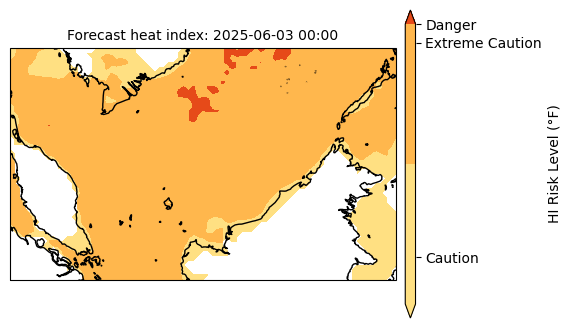

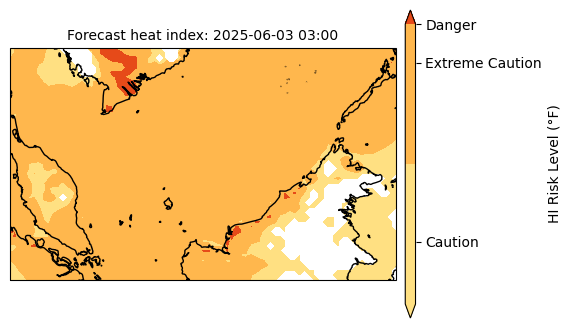

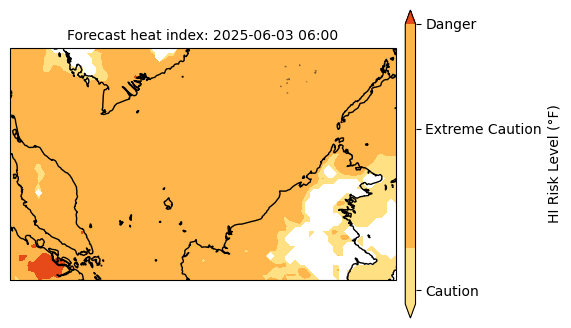

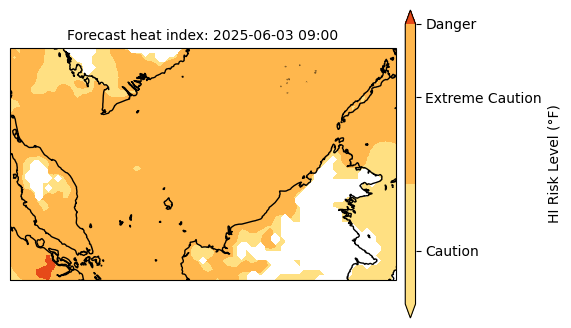

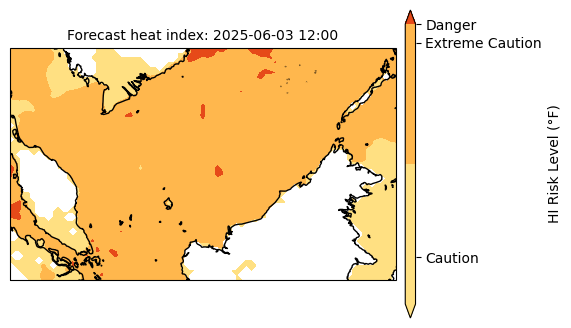

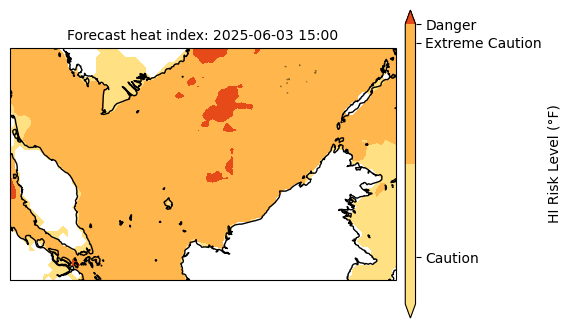

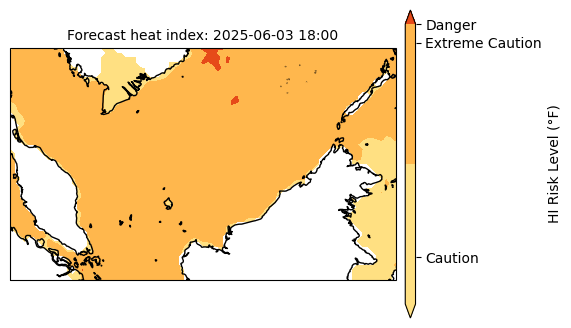

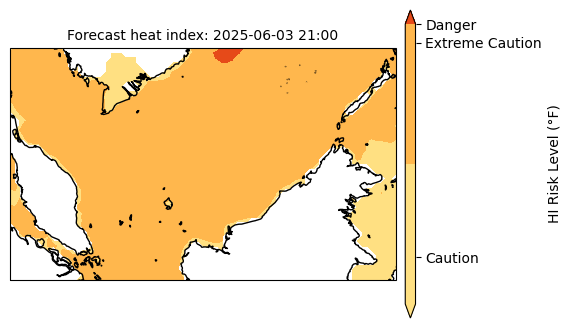

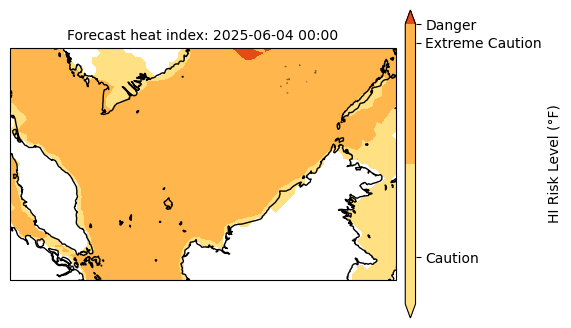

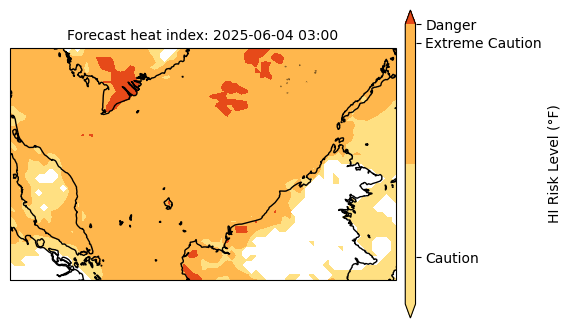

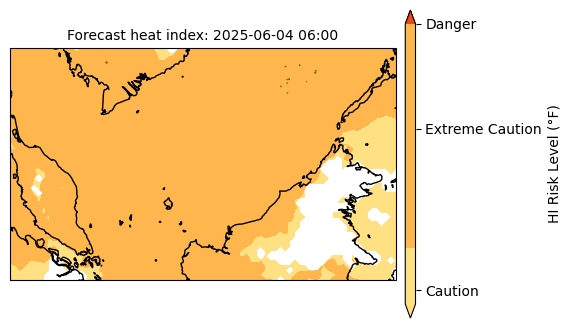

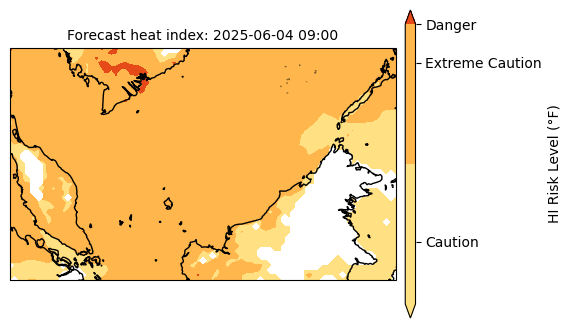

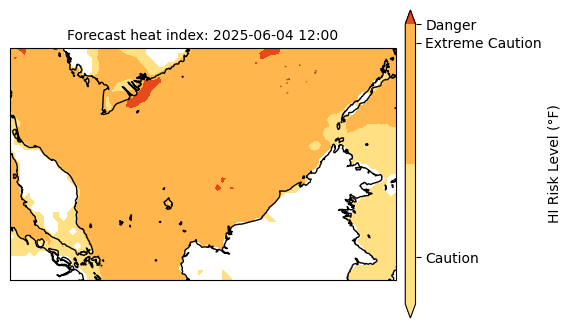

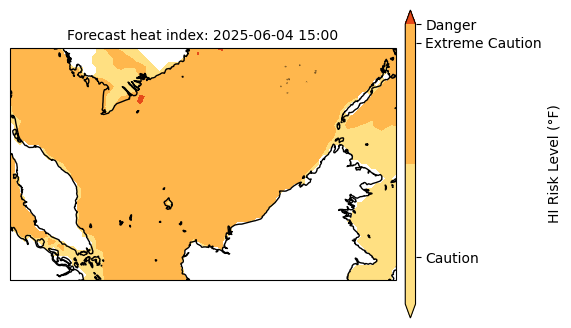

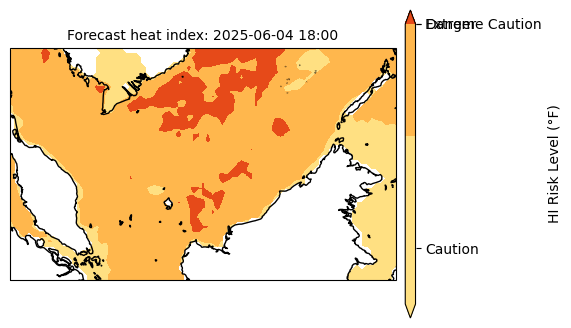

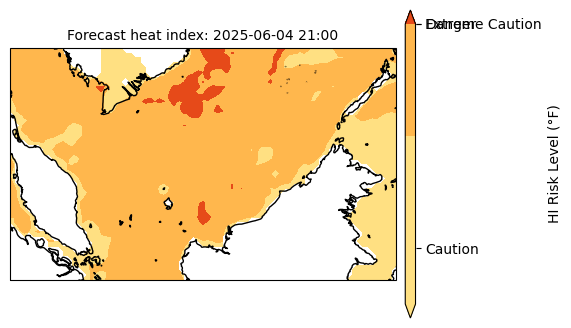

In [46]:
### limit up to 2 days forecast, 16 timesteps

longitude=HI_computed.lon
latitude=HI_computed.lat
data=HI_computed.values
timestep=HI_computed.time

idx = 0
while True:
    field = data[idx]
    forecast_time=timestep[idx]
    formatted_time = pd.to_datetime(forecast_time.values).strftime('%Y-%m-%d %H:%M')
    #masked out anything below 80F
    masked_field = np.where(field >= 80, field, np.nan)

    # Plot this timestep (simplified example)
    plt.figure(figsize=(6, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = ax.contourf(longitude, latitude, masked_field, transform=ccrs.PlateCarree(),cmap=cmap, norm=norm, extend='both')
    ax.coastlines()
    ax.set_title(f"Forecast heat index: {str(formatted_time)}", fontsize=10)
    cbar = plt.colorbar(im, orientation='vertical', pad=0.02, aspect=30)
    cbar.set_label("HI Risk Level (°F)")
    cbar.set_ticks([85, 96.5,113.5])  # approximate midpoints of the ranges
    cbar.set_ticklabels(labels)
    plt.show()

    idx += 1
    if idx >= 16:  # this simulates the "while" part of "do-while"
        break